### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPUMapping import MappingFilter
from BabelBrain.GPUFunctions.GPUResample import Resample

/Users/acoreas/opt/miniconda3/envs/bbl_dev/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/acoreas/Documents/GitHub/BabelBrain


### GPU Initialization

In [2]:
# GPUBackend='CUDA'
# GPUBackend='OpenCL'
GPUBackend='Metal'
gpu_name = 'Apple M1 Max'

MappingFilter.InitMapFilter(gpu_name,GPUBackend=GPUBackend)
Resample.InitResample(gpu_name, GPUBackend=GPUBackend)

Selecting device:  Device(gpu, 0)
Selecting device:  Device(gpu, 0)


### Load Input Data

In [3]:
scan_type = 'T1W'
folder_path = '/Users/acoreas/Documents/unit_test_data/SDR_0p31/'
base_name_1 = folder_path + f'm2m_SDR_0p31{os.sep}final_tissues'
base_name_2 = folder_path + scan_type
fname_1 = base_name_1 + '.nii.gz'
fname_2 = base_name_2 + '.nii.gz'
nifti_1 = nibabel.load(fname_1)
nifti_2 = nibabel.load(fname_2)
data_1 = nifti_1.get_fdata()[:,:,:,0]
data_2 = nifti_2.get_fdata()
nifti_1 = nifti1.Nifti1Image(data_1,nifti_1.affine)

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolution_level = {
    '0': 0.919,    # 200 kHz,   6 PPW
    '1': 0.613,    # 200 kHz,   9 PPW
    '2': 0.459,    # 200 kHz,  12 PPW
    '3': 0.306,    # 600 kHz,   6 PPW
    '4': 0.204,    # 600 kHz,   9 PPW
    '5': 0.153,    # 600 kHz,  12 PPW
    '6': 0.184,    # 1000 kHz,  6 PPW
    '7': 0.123,    # 1000 kHz,  9 PPW
    '8': 0.092,    # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolution_level['0'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti_2.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti_2.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti_2.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti_2.shape[2]/(spatial_step[2]/zooms[2]))
T1W_affine_upscaled = affines.rescale_affine(nifti_2.affine.copy(),
                                         nifti_2.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,T1W_affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [1.0002484  0.99999994 0.99999994]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (204, 278, 278)
Output Size: 15765936


### Run Resample Step

In [5]:
# Select a resample method
resample_method = 'CPU' # Truth method, accurate but takes longer especially for higher resolutions
# resample_method = 'GPU' # Much faster, but can have slight deviations from truth. Acceptable for purposes of this test.
print(f"Resampling via {resample_method}")

# Set resample order and mode (default is 3 and 'constant')
order = 0
mode = 'constant' #'nearest'


if resample_method == 'CPU':
    # Reload file if it was created already, otherwise generate and save file
    resampled_fname_1 = folder_path + f"final_tissues_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    resampled_fname_2 = folder_path + f"{scan_type}_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"

    # File 1
    if os.path.exists(resampled_fname_1):
        print('Reloading file')
        resampled_nifti_1 = nibabel.load(resampled_fname_1)
        resampled_data_1 = resampled_nifti_1.get_fdata()
    else:
        print('Generating file')
        resampled_nifti_1 = processing.resample_from_to(nifti_1,output_nifti,mode=mode,order=order,cval=data_1.min()) # Truth method
        print('Saving file')
        nibabel.save(resampled_nifti_1,resampled_fname_1)
        print('Collecting data')
        resampled_data_1 = resampled_nifti_1.get_fdata()
    
    # File 2
    if os.path.exists(resampled_fname_2):
        print('Reloading file')
        resampled_nifti_2 = nibabel.load(resampled_fname_2)
        resampled_data_2 = resampled_nifti_2.get_fdata()
    else:
        print('Generating file')
        resampled_nifti_2 = processing.resample_from_to(nifti_2,output_nifti,mode=mode,order=order,cval=data_2.min()) # Truth method
        print('Saving file')
        nibabel.save(resampled_nifti_2,resampled_fname_2)
        print('Reloading file')
        resampled_data_2 = resampled_nifti_2.get_fdata()
elif resample_method == 'GPU':
    # Generating file is typically faster than reloading a saved file
    
    # File 1
    print('Generating file')
    resampled_nifti_1 = Resample.ResampleFromTo(nifti_1,output_nifti,mode=mode,order=order,cval=data_1.min(),GPUBackend=GPUBackend)
    resampled_data_1 = resampled_nifti_1.get_fdata()
    
    # File 2
    print('Generating file')
    resampled_nifti_2 = Resample.ResampleFromTo(nifti_2,output_nifti,mode=mode,order=order,cval=data_2.min(),GPUBackend=GPUBackend)
    resampled_data_2 = resampled_nifti_2.get_fdata()

Resampling via CPU
Reloading file
Reloading file


### Prepare Data

In [6]:
# Check input data dtype
if resampled_data_1.dtype != np.float32:
    print("Changing input data to be of float32 datatype")
    resampled_data_1 = resampled_data_1.astype(np.float32)
if resampled_data_2.dtype != np.float32:
    print("Changing input data to be of float32 datatype")
    resampled_data_2 = resampled_data_2.astype(np.float32)
    
# Check input data is contiguous
if not resampled_data_1.flags.contiguous:
    print("Changing input data to be a contiguous array")
    resampled_data_1 = np.ascontiguousarray(resampled_data_1)
if not resampled_data_2.flags.contiguous:
    print("Changing input data to be a contiguous array")
    resampled_data_2 = np.ascontiguousarray(resampled_data_2)
    

SelBone = (resampled_data_1==7)
print(SelBone.shape,resampled_data_2.shape)
UniqueHU=np.unique(resampled_data_2[SelBone])
print(UniqueHU.shape,len(UniqueHU))

Changing input data to be of float32 datatype
Changing input data to be of float32 datatype
Changing input data to be a contiguous array
Changing input data to be a contiguous array
(204, 278, 278) (204, 278, 278)
(3925,) 3925


### Run Map Filter Step

In [ ]:
with CodeTimer("Map Filter via GPU", unit="s"):
    data_map_gpu=MappingFilter.MapFilter(resampled_data_2,SelBone.astype(np.uint8),UniqueHU,GPUBackend=GPUBackend)

with CodeTimer("Map Filter via CPU", unit="s"):
    print(f"Starting Map Filter")
    CTMap_truth_fname = folder_path + f"map_filter_CPU_{scan_type}_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(CTMap_truth_fname):
        print("Reloading CPU file")
        data_map_cpu = nibabel.load(CTMap_truth_fname).get_fdata().astype(np.uint32)
    else:
        print("Generating CPU file")
        data_map_cpu=np.zeros(resampled_data_2.shape,np.uint32)
        for n,d in enumerate(UniqueHU):
            data_map_cpu[resampled_data_2==d]=n
        data_map_cpu[SelBone==False]=0

        nifti_map_filter_cpu = nibabel.Nifti1Image(data_map_cpu,T1W_affine_upscaled)
        print('Saving CPU file')
        nibabel.save(nifti_map_filter_cpu,CTMap_truth_fname)

# Ensure arrays are same size and dtype
if  data_map_gpu.size != data_map_cpu.size:
    print(f"Array sizes don't match: {data_map_cpu.size} vs {data_map_cpu.size}")
if  data_map_gpu.size == 0:
    print("Arrays are empty")
if  data_map_gpu.size == data_map_cpu.dtype:
    print("Arrays have different dtypes, changing them to match")
    data_map_gpu.astype(data_map_cpu.dtype)
    

INFO:root:
Starting Map Filter
INFO:root:Step size: 240000000
INFO:root:Total points: 15765936
INFO:root:Working on slices 0 to 204 out of 204


Code block 'Map Filter via GPU' took: 0.16641 s
Starting Map Filter
Reloading CPU file
Code block 'Map Filter via CPU' took: 0.11192 s


### Plot Data

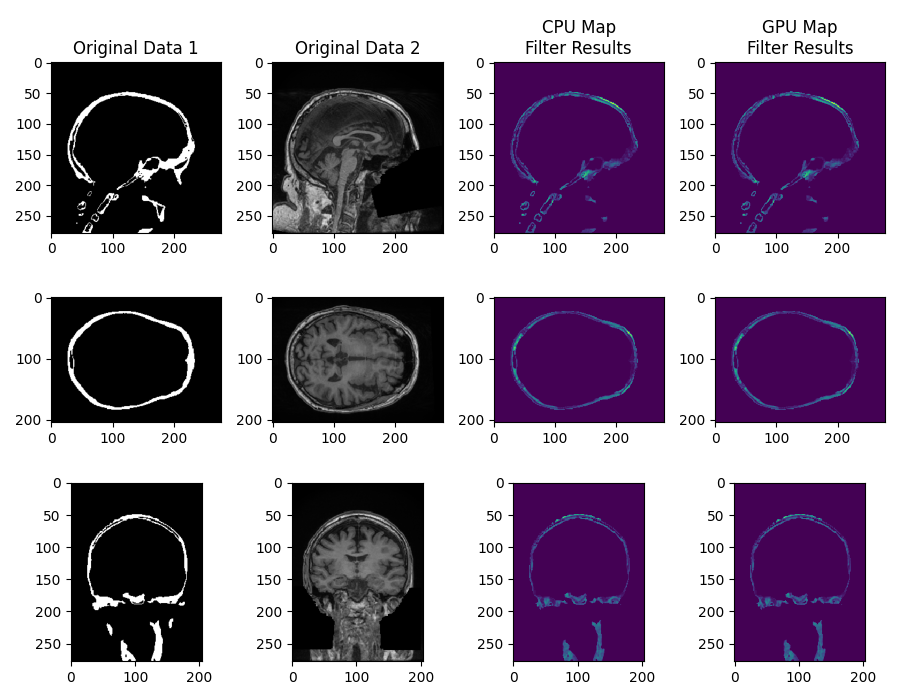

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(9, 7))

slice_num = resampled_data_1.shape[0]//2
axs[0,0].set_title("Original Data 1")
axs[0,0].imshow(np.rot90(SelBone[slice_num,:,:]), cmap='gray')
axs[0,1].set_title("Original Data 2")
axs[0,1].imshow(np.rot90(resampled_data_2[slice_num,:,:]), cmap='gray')
axs[0,2].set_title("CPU Map\nFilter Results")
axs[0,2].imshow(np.rot90(data_map_cpu[slice_num,:,:]))
axs[0,3].set_title("GPU Map\nFilter Results")
axs[0,3].imshow(np.rot90(data_map_gpu[slice_num,:,:]))

slice_num = resampled_data_1.shape[2]//2
axs[1,0].imshow(SelBone[:,:,slice_num], cmap='gray')
axs[1,1].imshow(resampled_data_2[:,:,slice_num], cmap='gray')
axs[1,2].imshow(data_map_cpu[:,:,slice_num])
axs[1,3].imshow(data_map_gpu[:,:,slice_num])

slice_num = resampled_data_1.shape[1]//2
axs[2,0].imshow(np.rot90(SelBone[:,slice_num,:]), cmap='gray')
axs[2,1].imshow(np.rot90(resampled_data_2[:,slice_num,:]), cmap='gray')
axs[2,2].imshow(np.rot90(data_map_cpu[:,slice_num,:]))
axs[2,3].imshow(np.rot90(data_map_gpu[:,slice_num,:]))

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()

### Check Output Data Matches Truth Data

In [9]:
data_match = np.all(data_map_cpu==data_map_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(data_map_gpu - data_map_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (data_map_cpu.size + data_map_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(data_map_gpu - data_map_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0,0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1,0].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2,0].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(data_map_cpu,data_map_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(data_map_cpu,data_map_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
